<h2>Importación de librerias</h2>

In [ ]:
# Visualization Libraries
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# Operational Libraries
import pandas as pd
import re
import dask.dataframe as dd
import numpy as np

<h2>1. Carga de datos desde excel a dataframes de pandas</h2>


En primer lugar voy a cargar cada uno de los csv a unos dataframes de pandas para ir manejandolos desde aqui. La idea es ir cruzando algunos excels y ver qué graficos interesantes van saliendo de los datos que tenemos. Los voy a cargar todos de una vez y a continuación los veremos en tablas para ir describiendolos

Esto puede tomar un ratito

In [ ]:
df_informacion_de_clientes = pd.read_csv('Informacion_Clientes.csv')
df_simulaciones_clientes = pd.read_csv('Simulaciones_Clientes.csv')
df_tratamiento = pd.read_csv('Tratamiento.csv')
df_ventas = pd.read_csv('Ventas.csv')

<h3>1.1 Carga de 'Informacion_Clientes.csv'</h3>

En primer lugar se cargará la información de los clientes. Esto incluye las siguientes características de los clientes:

* **unnamed**: algo como uid
* **Rut**: identificador de Chile (supongo que por privacidad va desde 0 a max de observaciones)
* **Género**: Masculino o femenino
* **Categoría_Digital**: Si el cliente es digital o no
* **Elasticidad_Precios**: Baja, media o alta
* **Nacionalidad**: Chileno o extranjero
* **Propensión**: Número entre 0 y 1 que idica ??
* **Probabilidad_No_Pago**: Número entre 0 y 1 que indica la probabilidad de que el cliente no pague la deuda
* **Edad**: Numero entero de edad en años
* **Renta**: Renta promedio de los últimos 12 meses
* **Oferta_Consumo**: Monto máximo que puede cursar un cliente dado sus antecedentes crediticios y situación socioeconómica. 
* **Deuda_CMF**: Deuda que tiene el cliente en otros bancos. Efectivamente es deuda pendiente, pero de créditos otorgados por la competencia.
* **Tiempo_como_cliente**: Número de tiempo(no sé en que medida está) que el cliente lleva en el banco


In [ ]:
df_informacion_de_clientes

In [ ]:
df_informacion_de_clientes['Genero'].nunique()

In [ ]:
tiempo_como_cliente_maximo = df_informacion_de_clientes['Tiempo_como_cliente'].max()
tiempo_como_cliente_minimo =df_informacion_de_clientes['Tiempo_como_cliente'].max()
print(f'Tiempo máximo como cliente: {tiempo_como_cliente_maximo}\nTiempo mínimo como cliente: {tiempo_como_cliente_minimo}')

Algo interesante es que tiempo como cliente es solamente '2'

<h3>1.2 Carga de 'Simulaciones_Clientes.csv'</h3>

En segundo lugar se cargaran las simulaciones hechas por los clientes en la página del banco. Esto incluye las siguientes características de las simulaciones:
* **unnamed**: Supongo que es el número de simulacion registrada, un tipo de identificador de la simulación
* **fecha**: yyyy-mm-dd fecha de la simulación
* **rut**: identificador de Chile del cliente que hizo la simulacion
* **monto_simulado**: monto prestado al cliente
* **plazo_simulado**: plazo en **meses** del crédito
* **tasa_simulado**: costo para el cliente del credito

In [ ]:
df_simulaciones_clientes[df_simulaciones_clientes['rut'] == 9]

Lo interesante es que con el rut se pueden cruzar el dataframe de informacion de cliente y del plazo simulado

Para futuro manejo voy a renombrar la columna 'fecha'

In [ ]:
df_simulaciones_clientes.rename(columns={'fecha': 'fecha_simulacion'}, inplace=True)

<h3>1.3 Carga de 'Tratamiento.csv'</h3>

En tercer lugar se cargara el tratamiento que ha tenido el banco con el cliente, es decir, cómo se han contactado con él. Esto incluye las siguientes características:

* **unnamed**: Número de tratamiento registrado
* **fecha**: yyyy-mm-dd
* **rut**: Identificador de Chile del cliente con el que se tiene el tipo de trato
* **n_correos**: Cantidad de correos que se enviaron en el mes que sale la fecha. Es decir, si sele fecha '2024-03-01', correspondería a los correos enviados en marzo de 2024.
* **asg_ejec**: Si el cliente tiene un ejecutivo asignado

-[Notas de jp]: Este es el que más me costo entender, está registrado el tratamiento por fecha. Hay muchos más tratamientos(3 millones y medio) que clientes(500 mil clientes) por lo que supongo que el tipo de trato que le dan al cliente pudo haber cambiado en el tiempo. No estoy seguro si la cantidad de correos es un recuento del total de correos hasta la fecha o cuantos se les envió esa fecha.

In [ ]:
df_tratamiento

Para futuro manejo voy a renombrar la columna 'fecha'

In [ ]:
df_tratamiento.rename(columns={'fecha': 'fecha_tratamiento'}, inplace=True)

<h3>1.4 Carga de 'Ventas.csv'</h3>

Por último se cargaran las ventas que ha tenido el banco con el cliente. Esto incluye las siguientes características:

* **unnamed**: Índice sin significado
* **fecha**: yyyy-mm-dd -> fecha en la que se concretó la venta
* **rut**: identificador de Chile del cliente al que se le concretó la venta

In [ ]:
df_ventas

Para futuro manejo voy a renombrar la columna 'fecha'

In [ ]:
df_ventas.rename(columns={'fecha': 'fecha_venta'}, inplace=True)

<h2>2. Joints de datos<h2>


Ya con todos los df cargados se pueden ir cruzando algunos de ellos para poder ir sacando algunas conclusiones.

El primer joint que haré es la informacion de los clientes y la simulacion. 

Quiero saber: de todos mis clientes quienes son los que simulan. Por lo tanto, para cada uno de los clientes que exista en la base de informacion de clientes quiero tener la informacion de sus simulaciones (o no simulaciones es que no han simulado). Esto es interesante para saber si simulan o no.

In [ ]:
df_simulaciones_e_informacion_de_clientes = pd.merge(df_informacion_de_clientes, df_simulaciones_clientes, on='rut', how='left')

Revisaremos si hay algun NaN en este merge, es decir, si algún cliente no ha simulado.

In [ ]:
df_simulaciones_e_informacion_de_clientes['Monto_Simulado'].isna().sum()

Con esto, podemos ver que hay 4 clientes de nuestros datos que no han simulado. 

No lo eliminare para ver si es que a pesar de no haber simulado aún asi el banco ha concretado una venta con ellos.

A continuación haré un procedimiento similar con las ventas

In [ ]:
df_simulaciones_e_informacion_de_clientes_ventas = pd.merge(df_simulaciones_e_informacion_de_clientes, df_ventas, on = 'rut', how='left')

In [ ]:
df_simulaciones_e_informacion_de_clientes_ventas

In [ ]:
df_simulaciones_e_informacion_de_clientes_ventas['fecha_venta'].isna().sum()

Esto indica que 118.503 simulaciones no resultaron en ventas concretas. Es importante recordar que, debido a las características de este dataset, el hecho de que un cliente aparezca en el archivo CSV de ventas implica que realizó un cursamiento en el crédito. Además, se mencionó que la fecha de cursamiento del crédito debe coincidir con la fecha en la que se realizó la simulación, lo que significa que el monto y el precio registrados corresponden a dicha simulación.

Ahora, lo que me interesa es poder ver de todos los clientes que simularon como distribuyen sus características. Para esto, voy a crear otro dataframe en el cual voy a eliminar algunas columnas y voy a remapear algunas otras de nombres a números.

Se copia el dataset para evitar futuros problemas

In [ ]:
dataset_simulacion_informacion_ventas_numerico = df_simulaciones_e_informacion_de_clientes_ventas.copy(deep=True)

<h3>2.1. Valores que no aportan información</h3>

En este caso, los atributos que no aportan informacion son: 'unnamed_x', 'tiempo_como_cliente', 'unnamed:0', 'Unnamed: 0_y'

In [ ]:
dataset_simulacion_informacion_ventas_numerico = dataset_simulacion_informacion_ventas_numerico.drop(['Unnamed: 0_x', 'Tiempo_como_cliente', 'Unnamed: 0', 'Unnamed: 0_y'], axis=1)

In [ ]:
dataset_simulacion_informacion_ventas_numerico

Recordemos que los datos pueden ser de cuatro tipos principalmente:

- Nominal: nombres (identificación y clasificación)
- Ordinal: orden (jerarquización, posición relativa)
- Intervalo: cuantificación (cero arbitrario)
- Escala: cuantificación (cero absoluto)

<h3>2.2. Valores Nominales</h3>

En este caso los valores nominales serían sexo(se asume que la diferencia de sexos no es jerarquica), la categoría digital, la nacionalidad(se asume que la nacionalidad no es jerarquica) y la elasticidad de precios(otorga clasificación) 

In [ ]:
# Para Sexo no hay jearquía
mapper_sex = {'Femenino': 0, 'Masculino': 1}
dataset_simulacion_informacion_ventas_numerico['Genero'] = dataset_simulacion_informacion_ventas_numerico['Genero'].replace(mapper_sex)

# Para Categoría digital no hay jearquía
mapper_digital = {'Cliente no Digital': 0, 'Cliente Digital': 1}
dataset_simulacion_informacion_ventas_numerico['Categoria_Digital'] = dataset_simulacion_informacion_ventas_numerico['Categoria_Digital'].replace(mapper_digital)

# Para Nacionalidad no hay jearquía
mapper_nationality = {'Extranjero': 0, 'Chileno': 1}
dataset_simulacion_informacion_ventas_numerico['Nacionalidad'] = dataset_simulacion_informacion_ventas_numerico['Nacionalidad'].replace(mapper_nationality)

# Para Elasticidad no hay jearquía solo clasificacion
mapper_nationality = {'Baja': 0, 'Media': 1, 'Alta': 2}
dataset_simulacion_informacion_ventas_numerico['Elasticidad_Precios'] = dataset_simulacion_informacion_ventas_numerico['Elasticidad_Precios'].replace(mapper_nationality)

Las otras variables ya son numéricas

Voy a crear una columna booleana para ver si cursó el credito

In [ ]:
dataset_simulacion_informacion_ventas_numerico['venta_concretada'] = np.where(
    dataset_simulacion_informacion_ventas_numerico['fecha_venta'].notna(), 1, 0
)

In [ ]:
dataset_corregido = dataset_simulacion_informacion_ventas_numerico.copy(deep=True)
print(dataset_corregido.dtypes)

In [ ]:
# Para Sexo no hay jearquía
mapper_sex = {'Femenino': 0, 'Masculino': 1}
dataset_corregido['Genero'] = dataset_corregido['Genero'].replace(mapper_sex)

# Para Categoría digital no hay jearquía
mapper_digital = {'Cliente no Digital': 0, 'Cliente Digital': 1}
dataset_corregido['Categoria_Digital'] = dataset_corregido['Categoria_Digital'].replace(mapper_digital)

# Para Nacionalidad no hay jearquía
mapper_nationality = {'Extranjero': 0, 'Chileno': 1}
dataset_corregido['Categoria_Digital'] = dataset_corregido['Categoria_Digital'].replace(mapper_nationality)

# Para Elasticidad no hay jearquía solo clasificacion
mapper_nationality = {'Baja': 0, 'Media': 1, 'Alta': 2}
dataset_corregido['Categoria_Digital'] = dataset_corregido['Categoria_Digital'].replace(mapper_nationality)

In [ ]:
dataset_corregido

Por problemas de memoria vamos a proceder a eliminar algunas variables muy pesadas desde ahora en adelante

In [32]:
import sys
for var_name in list(globals().keys()):
    print(f"{var_name}: {sys.getsizeof(globals()[var_name])} bytes")

__name__: 57 bytes
__doc__: 113 bytes
__package__: 16 bytes
__loader__: 16 bytes
__spec__: 16 bytes
__builtin__: 72 bytes
__builtins__: 72 bytes
_ih: 344 bytes
_oh: 640 bytes
_dh: 64 bytes
In: 344 bytes
Out: 640 bytes
get_ipython: 64 bytes
exit: 48 bytes
quit: 48 bytes
open: 136 bytes
_: 12149642149 bytes
__: 28 bytes
___: 12149642149 bytes
__vsc_ipynb_file__: 212 bytes
_i: 168 bytes
_ii: 792 bytes
_iii: 576 bytes
_i1: 258 bytes
plt: 72 bytes
px: 72 bytes
sns: 72 bytes
pd: 72 bytes
re: 72 bytes
dd: 72 bytes
np: 72 bytes
_i2: 271 bytes
df_informacion_de_clientes: 182935121 bytes
df_ventas: 233027956 bytes
_i3: 75 bytes
_3: 182935121 bytes
_i4: 95 bytes
_4: 28 bytes
_i5: 662 bytes
tiempo_como_cliente_maximo: 32 bytes
tiempo_como_cliente_minimo: 32 bytes
_i6: 111 bytes
_6: 2201 bytes
_i7: 133 bytes
_i8: 63 bytes
_8: 3552215778 bytes
_i9: 124 bytes
_i10: 58 bytes
_10: 233027956 bytes
_i11: 113 bytes
_i12: 177 bytes
_i13: 121 bytes
_13: 32 bytes
_i14: 186 bytes
_i15: 97 bytes
_15: 248103650

In [42]:
del sampled_data

import gc
gc.collect()

807815

In [ ]:
print(dataset_corregido.columns)


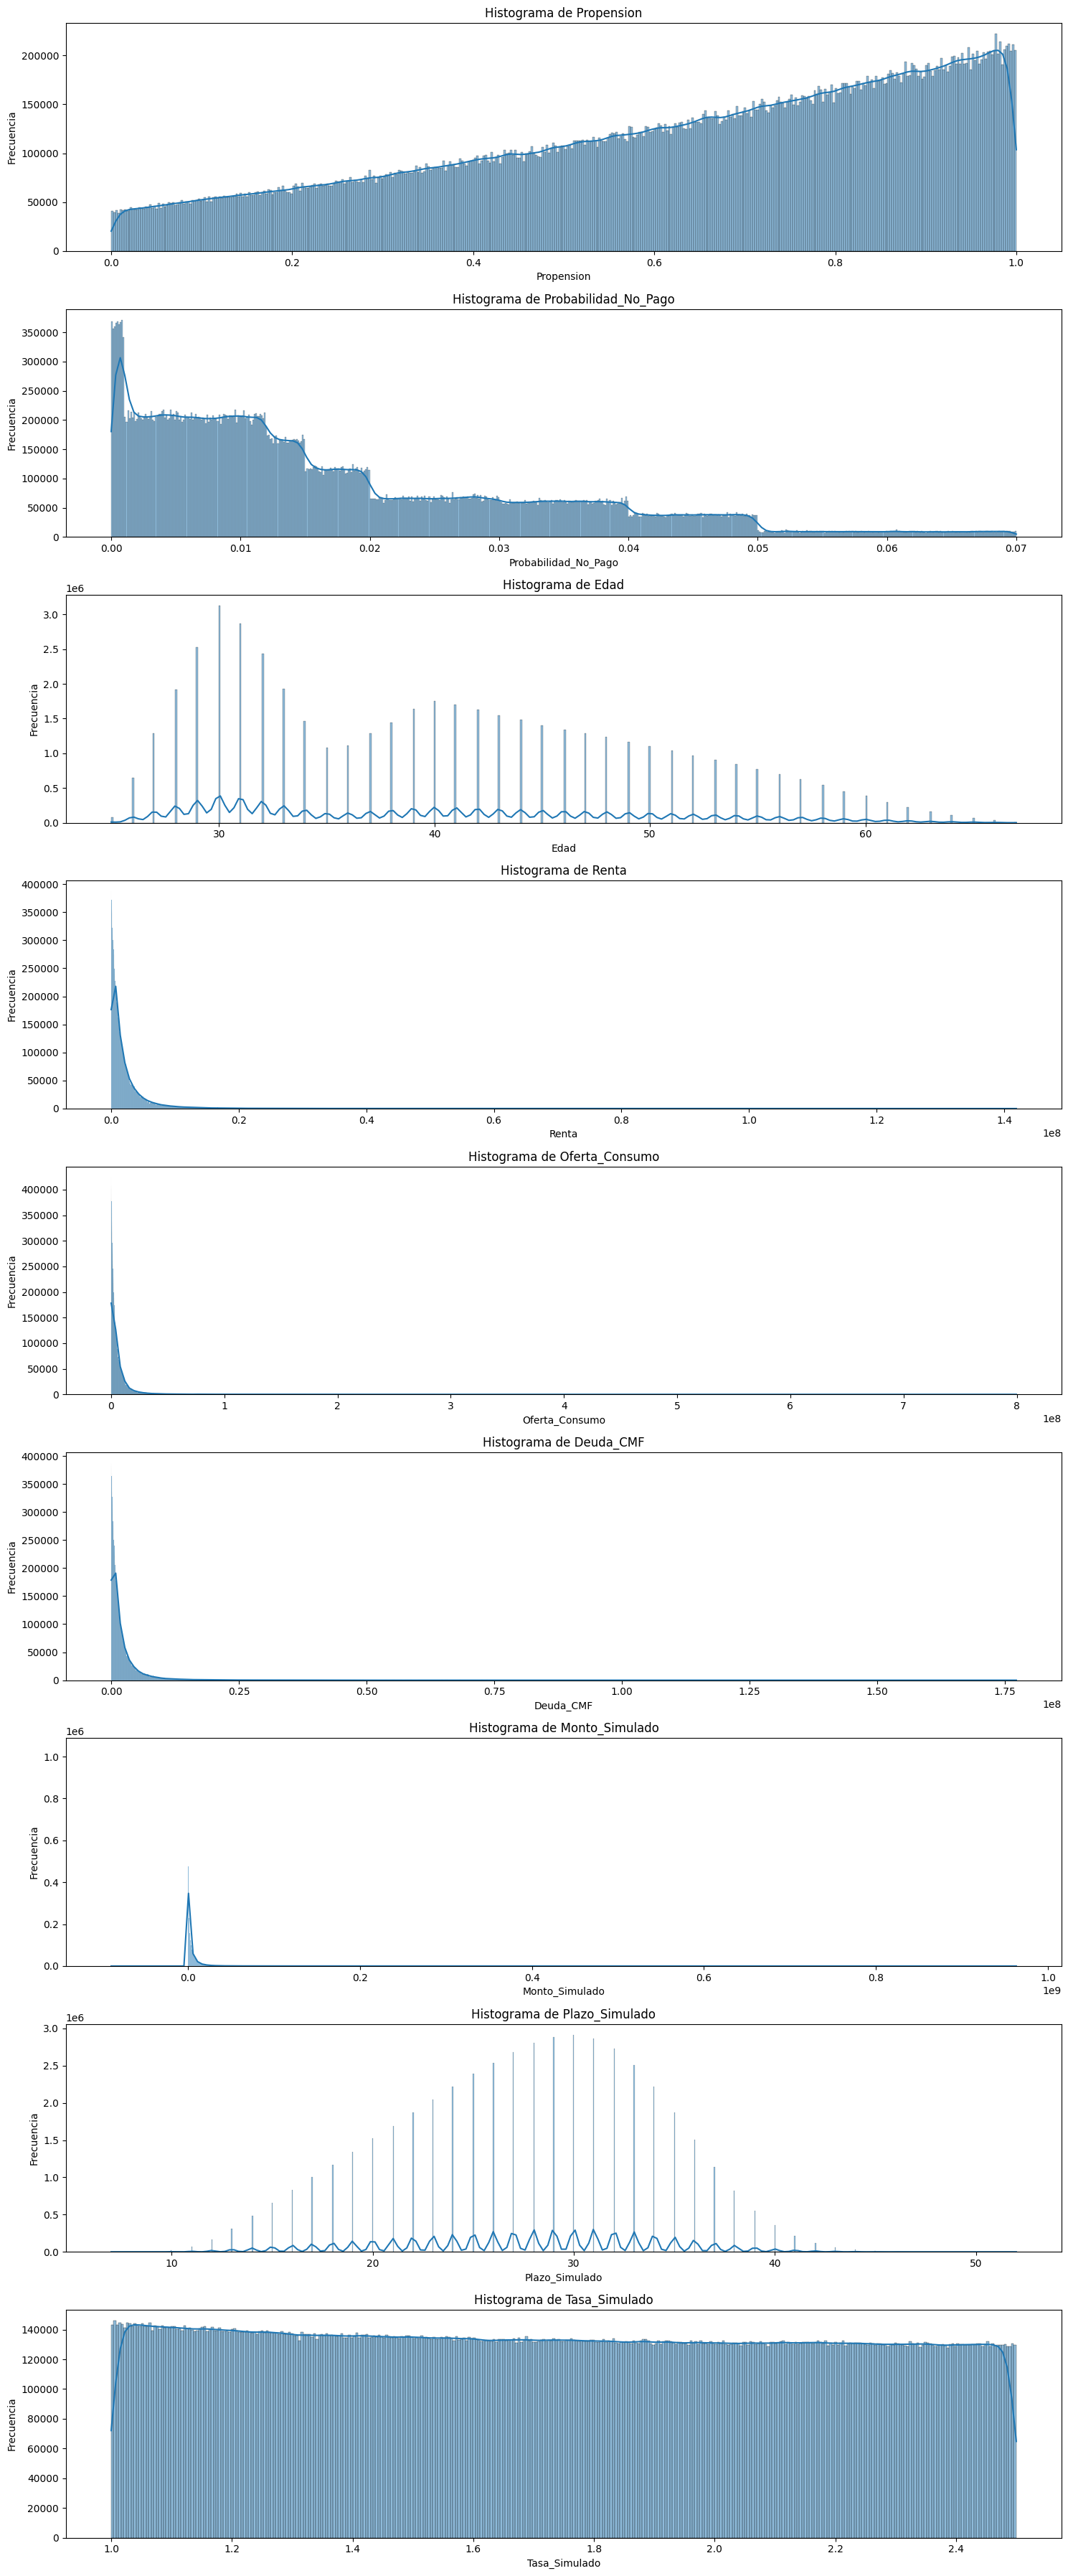

In [48]:
# Columnas a excluir
exclude_cols = ['rut', 'Genero', 'Elasticidad_Precios', 'Categoria_Digital', 'Nacionalidad']

# Filtrar columnas numéricas y excluir las específicas
numeric_cols = [col for col in dataset_corregido.select_dtypes(include=['int64', 'float64']).columns if col not in exclude_cols]

# Tomar una muestra del DataFrame
sampled_data = dataset_corregido.sample(n=100000, random_state=1)  # Ajusta el tamaño según sea necesario

# Configurar el tamaño de la figura
plt.figure(figsize=(15, len(numeric_cols) * 4))  # Ajusta el tamaño según el número de columnas

# Crear un histograma para cada columna numérica filtrada
for i, col in enumerate(numeric_cols):
    plt.subplot(len(numeric_cols), 1, i + 1)
    sns.histplot(dataset_corregido[col], kde=True)
    plt.title(f'Histograma de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [50]:
# Excluir columnas no deseadas
cols = [col for col in dataset_corregido.columns if col != ['rut', 'Genero', 'Elasticidad_Precios', 'Categoria_Digital', 'Nacionalidad']]
print(cols)

['rut', 'Genero', 'Categoria_Digital', 'Elasticidad_Precios', 'Nacionalidad', 'Propension', 'Probabilidad_No_Pago', 'Edad', 'Renta', 'Oferta_Consumo', 'Deuda_CMF', 'fecha_simulacion', 'Monto_Simulado', 'Plazo_Simulado', 'Tasa_Simulado', 'fecha_venta', 'venta_concretada']


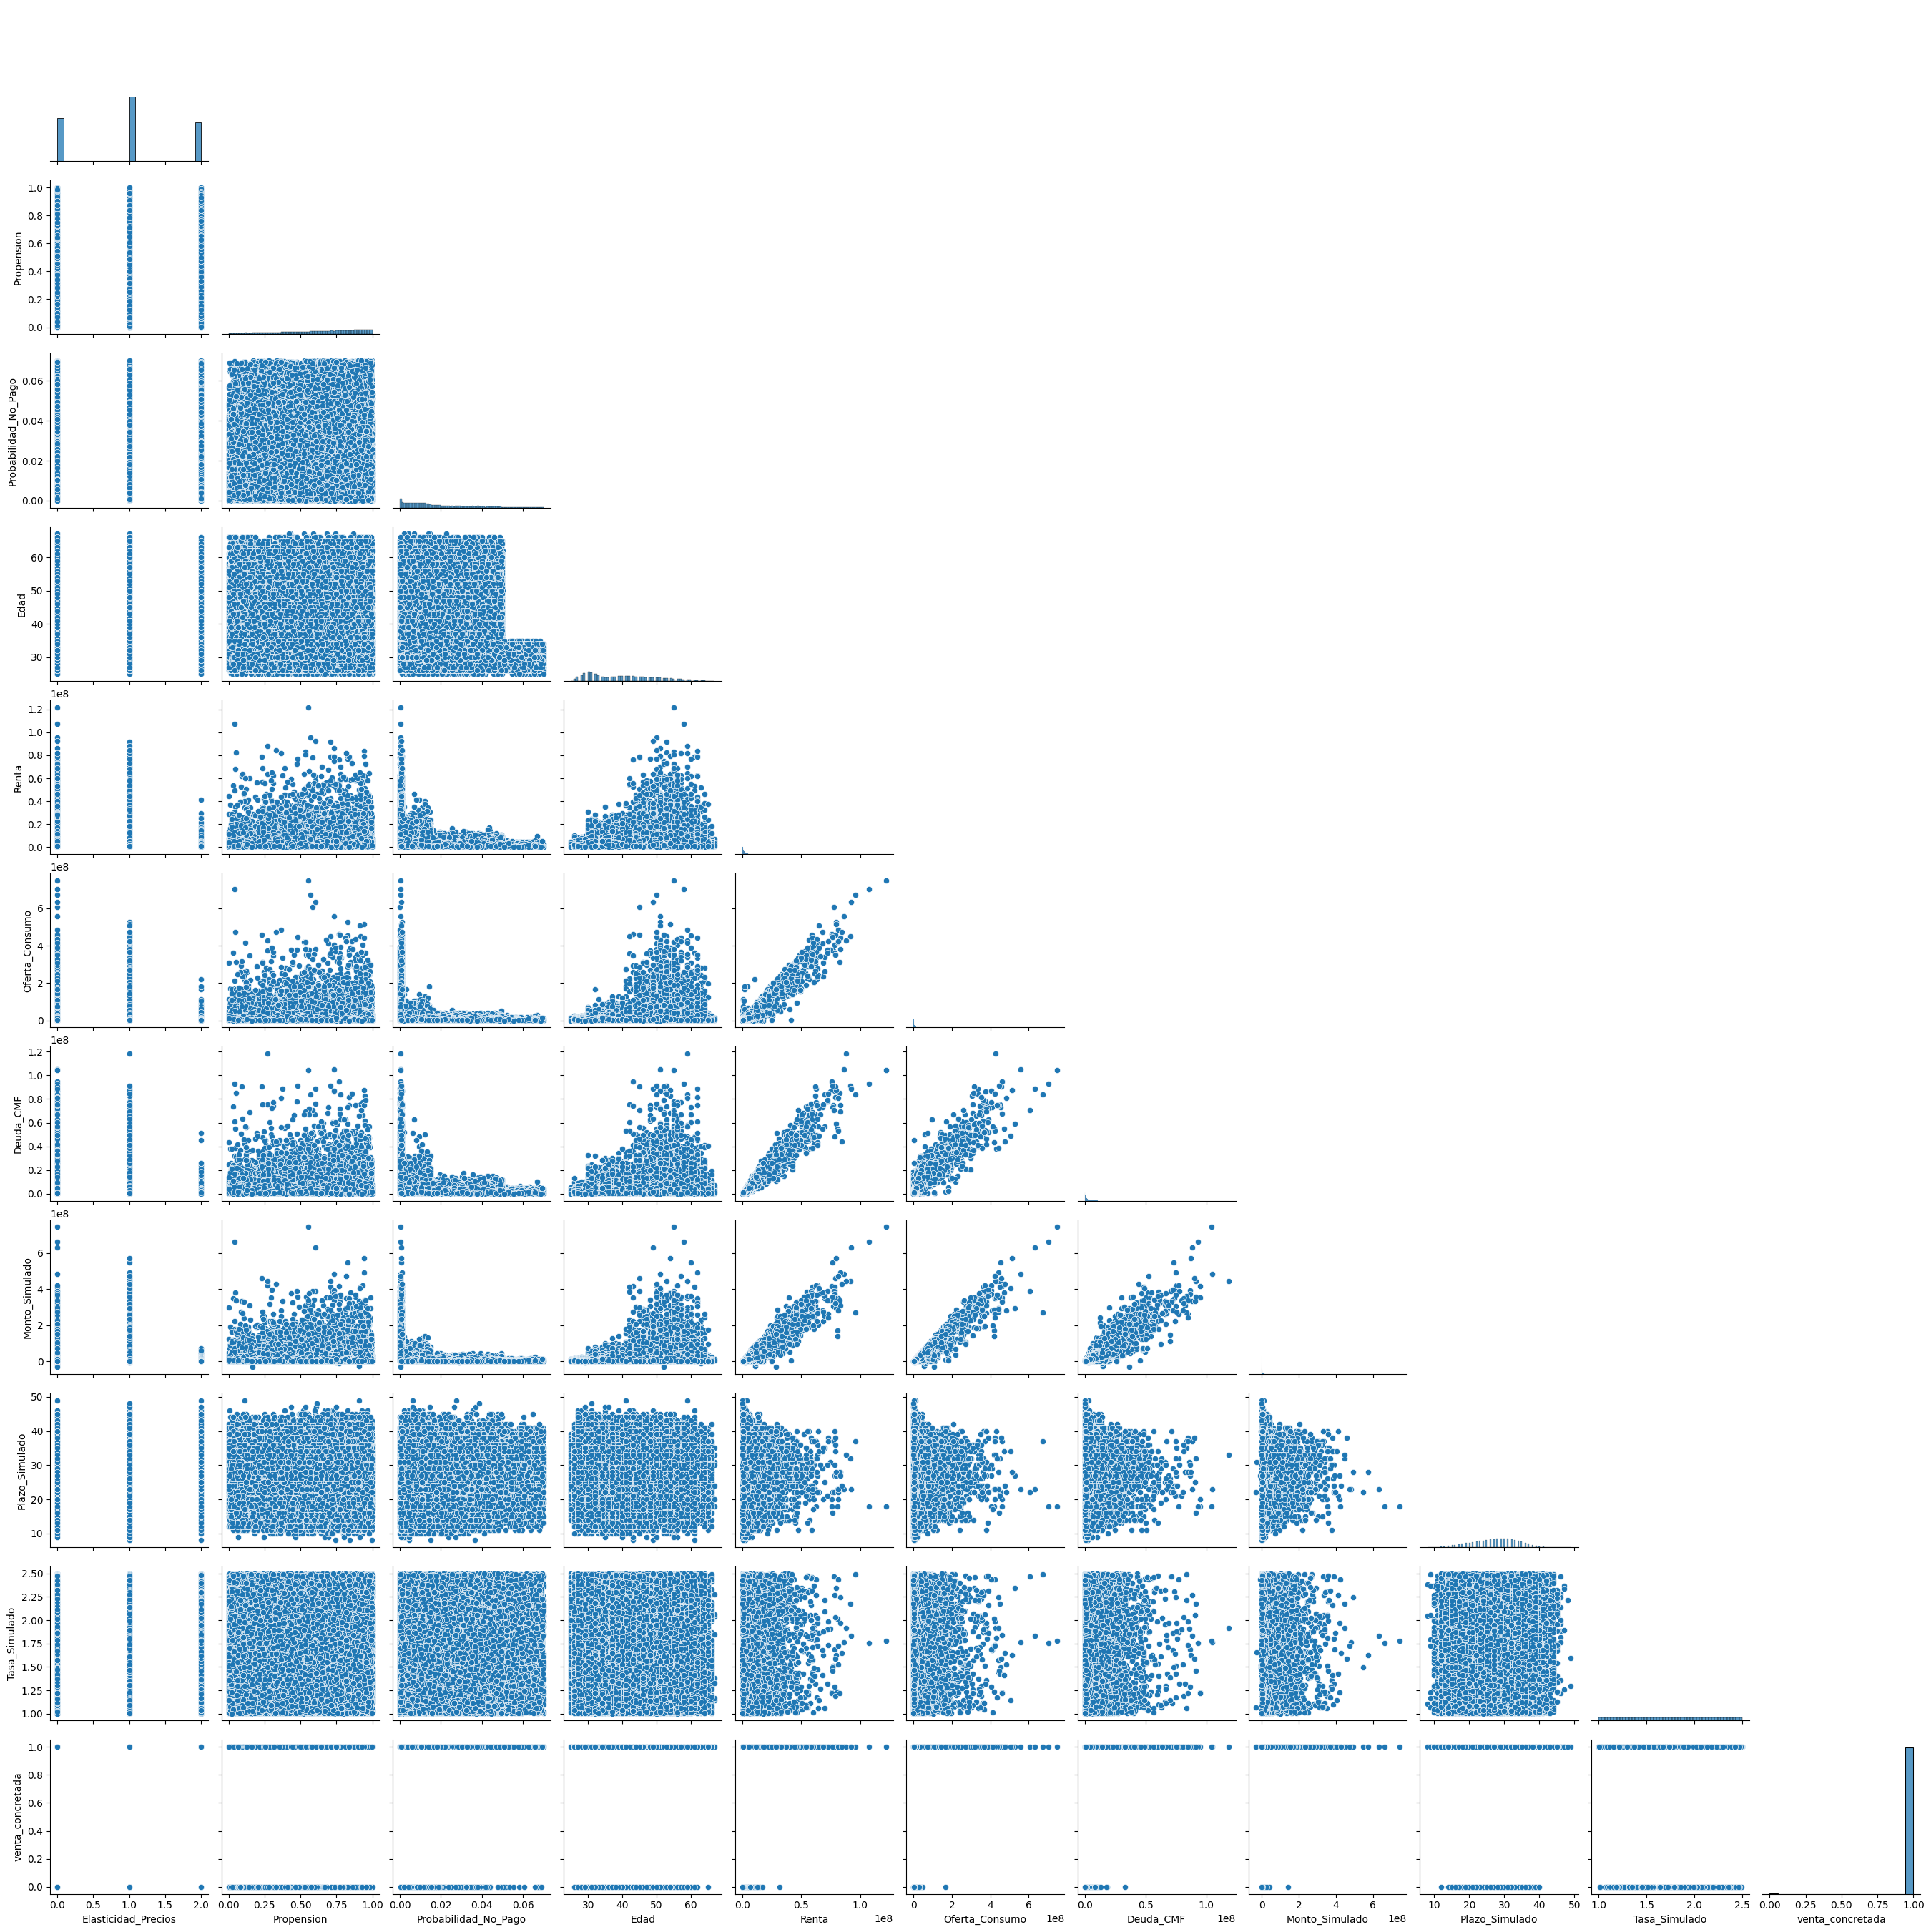

In [51]:

#Se seleccionan solo algunas columnas
cols = ['Elasticidad_Precios', 'Propension', 'Probabilidad_No_Pago', 'Edad', 'Renta', 'Oferta_Consumo', 'Deuda_CMF', 'Monto_Simulado', 'Plazo_Simulado', 'Tasa_Simulado', 'venta_concretada']
# Tomar una muestra del DataFrame
sampled_data = dataset_corregido.sample(n=100000, random_state=1)  # Ajusta el tamaño según sea necesario

# Crear el pairplot, solo la mitad inferior
pairwise_plot = sns.pairplot(sampled_data[cols], corner=True)

# Mostrar el gráfico
plt.show()